# Snake River irrigation topology: Case Study
Inne Vanderkelen - February 2021

#### Case study
- review all case studies in detail

#### Sensitivity testing
- Threshold (both tributaries and downstream) Di Baldassare et al 2017: reservoir downstream dependency: 200 km downstream. 

#### Data
- Find data irrigation demand: Look at study Voisin et al 
- Find original inflow-outflow data + look at papers SHin et al. (data? + approach with irrigation demand?)

Naoki remark: 

I like your suggestion, and it would not be difficult to group HRUs and assign the group of HRUs to a particular reservoir (could be done in river network data). One complexity (it is technical) is some of HRUs are likely handled in different MPI cores, and in that case, will have to communicate explicitly before extracting the water from those HRUs (river). it is not impossible, but more complicated than we would think. Inter-basin water transfer has similar problem. I was talking to Erik about similar problem the other day, might want to raise this again.

In [1]:
# import modules
# add path where utils modules are located to python path
import sys
sys.path.append('C:\\Users\\ivand\\OneDrive - Vrije Universiteit Brussel\\PhD\\3_reservoir_release\\water_demand\\')
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import pandas as pd
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

# import own functions
import pfaf.pfafstetter as pfaf # decode package from Naoki, see https://github.com/nmizukami/pfaf_decode 
from utils_plotting import *
from utils_irrigtopo import *

## 1. Load data + manual adjustments for case studies

In [2]:
# load data
river_shp = gpd.read_file('hdma_palisades_river_with_lake.shp')
hrus_shp = gpd.read_file('hdma_palisades_catch_simplify.shp')
res_shp = gpd.read_file('GRand_palisades_irr_reservoirs.shp')

# set WGS84 as coordinate reference system
river_shp = river_shp.set_crs(epsg=4326)
hrus_shp = hrus_shp.set_crs(epsg=4326)
res_shp  = res_shp.set_crs(epsg=4326)

# reproject to local projection system (UTM12) https://www.digtech-llc.com/blog/2011/7/3/22-shovelbums-guide-part-7-the-utm-grid.html 
river_shp = river_shp[river_shp.geometry != None]
river_shp = river_shp.to_crs("EPSG:32612")
hrus_shp = hrus_shp[hrus_shp.geometry != None]
hrus_shp = hrus_shp.to_crs("EPSG:32612")
res_shp = res_shp[res_shp.geometry != None]
res_shp = res_shp.to_crs("EPSG:32612")


In [3]:
# manually add other lakes to river network (now only Jackson is included)
river_shp.loc[river_shp.seg_id == 3039434, "islake"] = 1 # Palisades
river_shp.loc[river_shp.seg_id == 3031527, "islake"] = 1 # blackfoot
river_shp.loc[river_shp.seg_id == 3013833, "islake"] = 1 # Island Park

# manually assign pfafs of reservoirs
pfaf_palisades  = river_shp.loc[river_shp.seg_id == 3039434, "PFAF"].values[0]
pfaf_blackfoot  = river_shp.loc[river_shp.seg_id == 3031527, "PFAF"].values[0]
pfaf_islandpark = river_shp.loc[river_shp.seg_id == 3013833, "PFAF"].values[0]
pfaf_jackson    = river_shp.loc[river_shp.seg_id == 3030596, "PFAF"].values[0]

# get pfaf of outlet
pfaf_basin_outlet = pfaf.get_outlet(river_shp.loc[:,"PFAF"])
pfaf_basin_outlet = '31249775' # one segment up because real outlet is not working

# manually add lake volumes (necessary for weighting)
river_shp.loc[river_shp.PFAF == pfaf_palisades, "lake_Vol"] = 1480.2 # Palisades
river_shp.loc[river_shp.PFAF == pfaf_blackfoot, "lake_Vol"] = 505.7 # blackfoot
river_shp.loc[river_shp.PFAF == pfaf_islandpark, "lake_Vol"]= 157.0 # Island Park
river_shp.loc[river_shp.PFAF == pfaf_jackson, "lake_Vol"] = 1076.8 # Jackson

# assign pfaf values to GRanD shapefile (for plotting purposes only)
res_shp['PFAF'] = np.nan
res_shp.loc[res_shp['DAM_NAME']=='Island Park', 'PFAF'] = pfaf_islandpark
res_shp.loc[res_shp['DAM_NAME']=='Jackson Lake', 'PFAF'] = pfaf_jackson
res_shp.loc[res_shp['DAM_NAME']=='Palisades', 'PFAF'] = pfaf_palisades
res_shp.loc[res_shp['DAM_NAME']=='Blackfoot', 'PFAF'] = pfaf_blackfoot



In [4]:
pfaf_palisades

'31249913'

## 2. Plot catchment

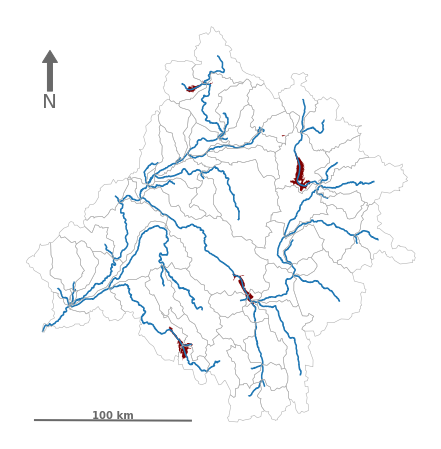

In [5]:
# remap water demand to HRU (now with runoff and rough remapping)
set_plot_param()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=ccrs.UTM(zone=12))
res_shp.plot(ax=ax, color='maroon', legend=True)
river_shp.plot(ax=ax, legend=True)
hrus_shp.boundary.plot(ax=ax, color='darkgray', linewidth=0.5)
plt.axis('off'); 
scale_bar(ax, 100 , location=(0.25, 0.05))
north_arrow(ax, location=(0.1,0.90), arrow_length=0.1)

plt.savefig('./plots/catchment.jpg')



## 3. Do functions to get topology

In [6]:
# Settings: 
outlet_threshold = 1000e3 # in m
tributary_threshold = 100e3 # m
river_shp

# get all reservoirs in river topology
pfaf_reservoirs = get_pfafs_res(river_shp)

# get their corresponding outlets
pfaf_outlets = get_outlets(river_shp,pfaf_reservoirs,outlet_threshold)

# get dependent reservoirs per segment
seg_dependency_dict = get_seg_dependency(pfaf_reservoirs, pfaf_outlets, river_shp, tributary_threshold)

# get weights of dependend reservoirs per segment
weights_dict = get_weights_per_seg(seg_dependency_dict, river_shp, pfaf_reservoirs,  weigh_smax_with_nseg=True)

# get depenent segments per reservoir and corresponding weights
res_dependency_dict = get_res_dependency_and_weights(pfaf_reservoirs, seg_dependency_dict, weights_dict)

-------- Searching for outlets --------

processing 1 of 4
reservoir: 3124988
river mouth reached

processing 2 of 4
reservoir: 31249997
reservoir reached

processing 3 of 4
reservoir: 31249783
river mouth reached

processing 4 of 4
reservoir: 31249913
river mouth reached

---------- All outlets found! ----------
processing reservoir 1 of 4
processing reservoir 2 of 4each 13 of 13
processing reservoir 3 of 4each 8 of 8
processing reservoir 4 of 4each 3 of 3
processing tributaries of reach 7 of 7
processing segment 15 of 44


## 6. Calculate total irrigation demand per reservoir

In [7]:
# open remapped irrigation and convert to correct unit (needs basinArea from ntopo dict)

hrus_shp_colombia = gpd.read_file('C:\\Users\\ivand\\OneDrive - Vrije Universiteit Brussel/PhD/3_reservoir_release/water_demand/casestudies/Columbia/hdma_columbia_catch_irrig.shp')
hrus_shp_colombia = hrus_shp_colombia[['hruid','_mean']]
hrus_shp = hrus_shp.merge(hrus_shp_colombia, on='hruid')
hrus_shp

ntopo = xr.open_dataset('C:\\Users\\ivand\\OneDrive - Vrije Universiteit Brussel/PhD/3_reservoir_release/data_for_mizuroute/ntopo_hdma_mod.reorder_lake.nc')
basin_area = ntopo[['Basin_Area','hruid']].to_dataframe()

hrus_shp = hrus_shp.merge(basin_area, on='hruid')
hrus_shp['basinIrrig'] = hrus_shp['_mean']* (10**-3) * hrus_shp['Basin_Area'] # m3/s

In [8]:
# actual calculation
demand_dict = calc_demand_per_res(hrus_shp, res_dependency_dict)
demand_dict

{'3124988': 11.624135557863701,
 '31249997': 2.1754664316218264,
 '31249783': 4.278320865326123,
 '31249913': 40.83597084089797}

## 7. Plots

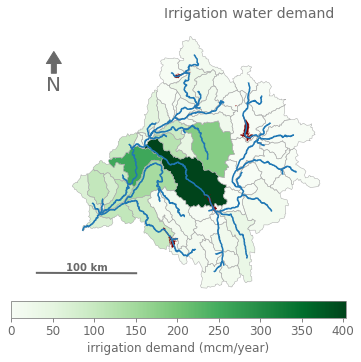

In [9]:
hrus_shp['Basin_Irrig_mcm_year-1'] = hrus_shp['basinIrrig'] * 31556926 / (10**6) # sec per year * MCM

# remap water demand to HRU (now with runoff and rough remapping)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection=ccrs.UTM(zone=12))
hrus_shp.boundary.plot(ax=ax, color='darkgray', linewidth=0.5)
hrus_shp.plot(ax=ax, column='Basin_Irrig_mcm_year-1',cmap='Greens',legend=True,legend_kwds={'label': "irrigation demand (mcm/year)",   'orientation': "horizontal", 'pad' : 0.001})
res_shp.plot(ax=ax, color='maroon', legend=True)
river_shp.plot(ax=ax, legend=True)
plt.axis('off'); 
plt.title('Irrigation water demand', loc='right'); 
scale_bar(ax, 100 , location=(0.1, 0.1))
north_arrow(ax, location=(0.1,0.90), arrow_length=0.1)

plt.savefig('./plots/HRU_demand.jpg')


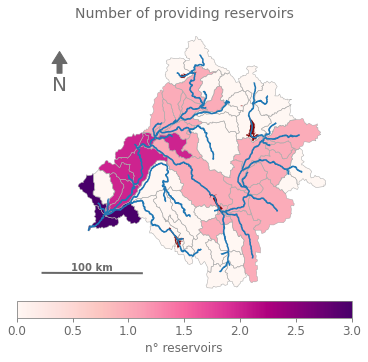

In [14]:
# calculate number of dependend reservoirs per hru. 
def count_res(row): 
    
    pfaf = row.PFAF
    if pfaf in seg_dependency_dict.keys():
        return len(seg_dependency_dict[pfaf])
    else:
          return 0

hrus_shp['n_res'] = hrus_shp.apply(lambda row: count_res(row),axis=1)


# plot number of dependend reservoirs per hru
# do plotting
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection=ccrs.UTM(zone=12))
hrus_shp.boundary.plot(ax=ax, color='darkgray', linewidth=0.5)
hrus_shp.plot(ax=ax, column='n_res',legend=True, cmap='RdPu',legend_kwds={'label': "n° reservoirs",   'orientation': "horizontal", 'pad' : 0.001}, alpha=1)

res_shp.plot(ax=ax, color='maroon')
river_shp.plot(ax=ax)
plt.axis('off'); 
plt.title('Number of providing reservoirs'); 

# Get colourbar from second axis
#colorbar = ax.get_figure().get_axes()[1]

# Apply some function f to each tick, where f can be your percentage conversion
#colorbar.set_ticks([0,2,4,6])
#colorbar.set_xticklabels(['0','1','2','3'])

scale_bar(ax, 100 , location=(0.1, 0.1))
north_arrow(ax, location=(0.1,0.90), arrow_length=0.1)

plt.savefig('./plots/providing_res_per_HRU.jpg')



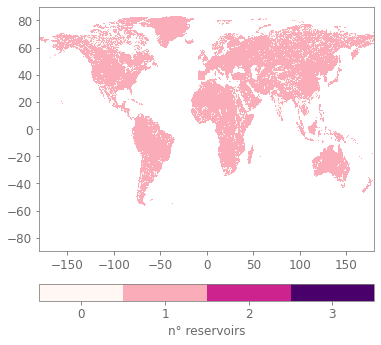

In [42]:
# plot categorized colorbar
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()

ds  = xr.open_dataset('runoff_sample.nc')

levels = [-1,0,1,2,3]
im = ds['runoff'].plot(ax=ax, levels=levels, cmap='RdPu',  add_colorbar=False, add_labels=False)
cb = plt.colorbar(im,pad= 0.1, extend='neither', orientation='horizontal', ticks = [-0.5,0.5,1.5,2.5])
cb.set_label(label = 'n° reservoirs', size=12)
cb.ax.tick_params(labelsize=12)
cb.ax.set_xticklabels(['0', '1', '2', '3'])  

plt.savefig('./plots/providing_res_per_HRU_cbar.jpg')


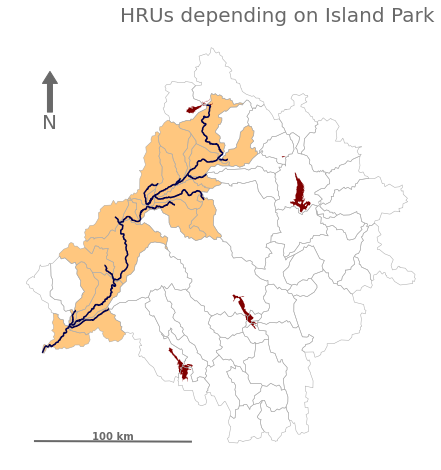

In [11]:
# Make plot for paper
pfaf_res = pfaf_islandpark
res_name='islandpark'
pfaf_outlet = pfaf_basin_outlet
pfaf_end = pfaf.get_outlet(river_shp.loc[:,"PFAF"])


pfaf_in_threshold = get_pfaf_resstream_and_in_tributary_threshold(pfaf_res, pfaf_outlet, river_shp, 200e3)
to_plot = exclude_higher_botelev(pfaf_in_threshold, pfaf_res, river_shp)
title='HRUs depending on Island Park'
figname='example_IslandPark'

river_shp['plot'] = np.nan
river_shp.loc[river_shp['PFAF'].isin(to_plot),'plot'] = 1
river_shp.loc[river_shp['PFAF'].isin(pfaf_end),'plot'] = 1

hrus_shp['plot'] = np.nan
hrus_shp.loc[hrus_shp['PFAF'].isin(to_plot),'plot'] = 1
hrus_shp.loc[hrus_shp['PFAF'].isin(pfaf_end),'plot'] = 1





fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=ccrs.UTM(zone=12))
hrus_shp.boundary.plot(ax=ax, color='darkgray', linewidth=0.5)
hrus_shp.plot(ax=ax, column='plot', cmap='copper_r')
river_shp.plot(ax=ax, column = 'plot', cmap='seismic')
res_shp.plot(ax=ax, color='maroon')


plt.axis('off'); 
plt.title(title,loc='right', fontsize=20)
scale_bar(ax, 100 , location=(0.25, 0.05))
north_arrow(ax, location=(0.1,0.90), arrow_length=0.1)

plt.savefig('./plots/'+figname+'.jpg')


In [12]:
pfaf_end

['31249773']

### Plot examples of reservoir rules 

In [63]:
# function to plot riversegments given by list of pfaf codes

def plot_pfaflist(to_plot,figname, title): 
    """# function to plot riversegments given by list of pfaf codes"""
    river_shp['plot'] = np.nan
    river_shp.loc[river_shp['PFAF'].isin(to_plot),'plot'] = 1

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection=ccrs.UTM(zone=12))
    res_shp.plot(ax=ax, color='maroon')
    river_shp.plot(ax=ax, column = 'plot')
    hrus_shp.boundary.plot(ax=ax, color='darkgray', linewidth=0.5)
    plt.axis('off'); 
    plt.title(title,loc='right', fontsize=14)
    scale_bar(ax, 100 , location=(0.25, 0.05))
    north_arrow(ax, location=(0.1,0.90), arrow_length=0.1)
    
    plt.savefig('./plots/'+figname+'.jpg')


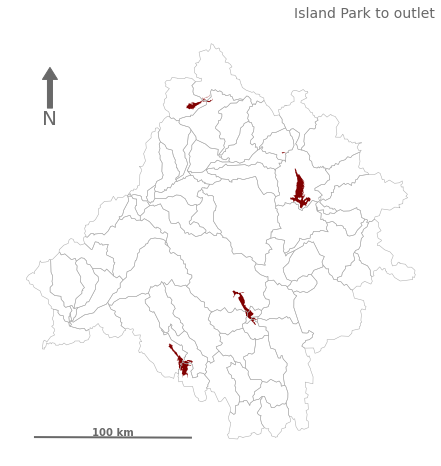

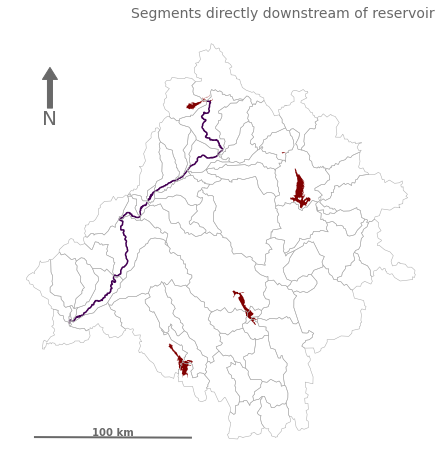

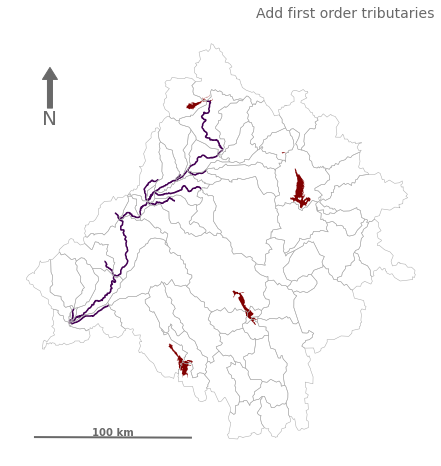

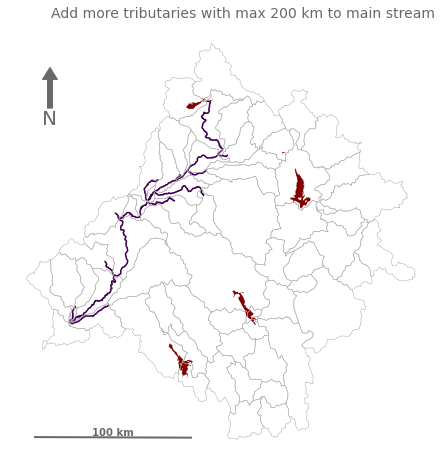

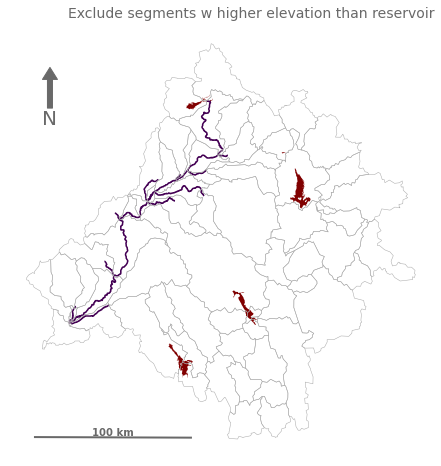

In [64]:
pfaf_reservoirs = [pfaf_jackson, pfaf_islandpark, pfaf_blackfoot, pfaf_palisades]
pfaf_outlets = [pfaf_palisades, pfaf_basin_outlet, pfaf_basin_outlet, pfaf_basin_outlet]


# Example: Island park
pfaf_res = pfaf_islandpark
res_name='islandpark'
pfaf_outlet = pfaf_basin_outlet

# 0. plot empty map
to_plot = []
figname='0_'+res_name+'_empty'
title='Island Park to outlet'
plot_pfaflist(to_plot,figname,title)

# 1. define reservoir stream to outlet
to_plot = get_pfafs_start2end(pfaf_res,pfaf_outlet,river_shp, include_end=False)
figname='1_'+res_name+'_res2outlet'
title='Segments directly downstream of reservoir'
plot_pfaflist(to_plot,figname,title)

# 2. Add first order tributaries
to_plot = get_pfaf_resstream_and_in_tributary_threshold(pfaf_res, pfaf_outlet, river_shp, 100)
figname='2_'+res_name+'_1sttrib'
title='Add first order tributaries'
plot_pfaflist(to_plot,figname, title)

# 3. Add first order tributaries
threshold=200e3 # 100km
to_plot = get_pfaf_resstream_and_in_tributary_threshold(pfaf_res, pfaf_outlet, river_shp, threshold)
figname='3_'+res_name+'_alltrib'
title='Add more tributaries with max '+str(int(threshold*10**-3))+' km to main stream'
plot_pfaflist(to_plot,figname, title)

# 4. Exclude segments that have higher Bottom elev than reservoir Bot elev
pfaf_in_threshold = get_pfaf_resstream_and_in_tributary_threshold(pfaf_res, pfaf_outlet, river_shp, threshold)
to_plot = exclude_higher_botelev(pfaf_in_threshold, pfaf_res, river_shp)
title='Exclude segments w higher elevation than reservoir'
figname='4_'+res_name+'_belowres'
plot_pfaflist(to_plot,figname, title)


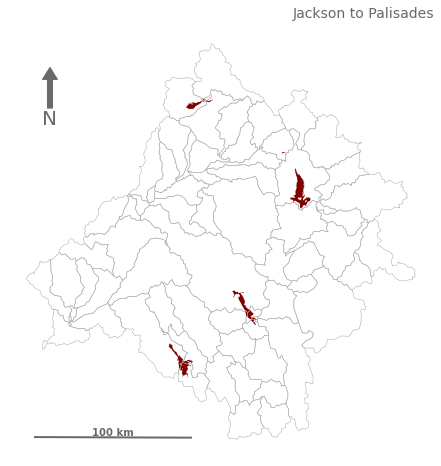

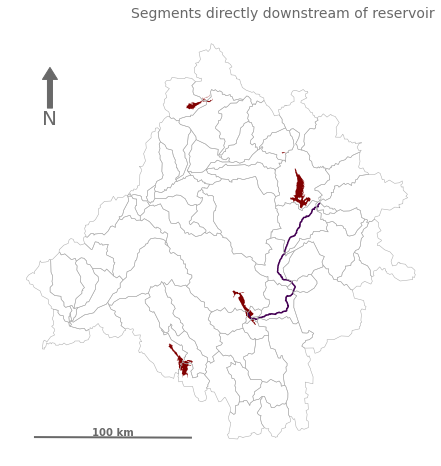

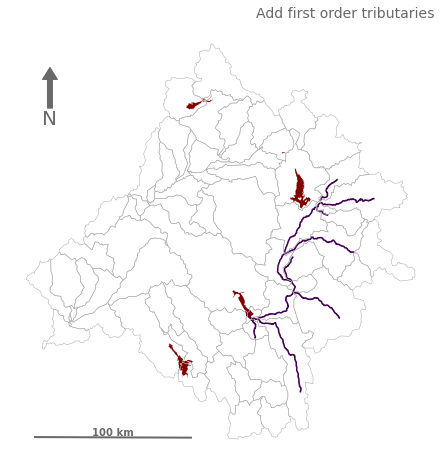

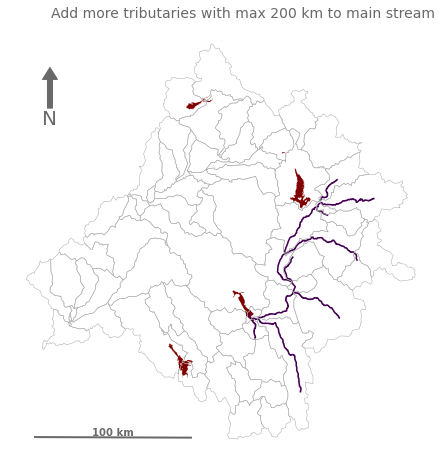

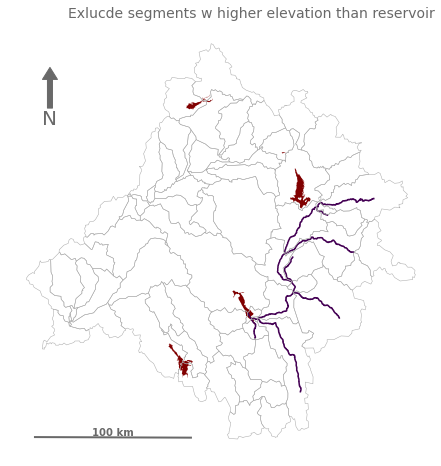

In [65]:
# Example: Island park
pfaf_res = pfaf_jackson
res_name='jackson'
pfaf_outlet = pfaf_palisades

# 0. plot empty map
to_plot = []
figname='0_'+res_name+'_empty'
title='Jackson to Palisades'
plot_pfaflist(to_plot,figname,title)

# 1. define reservoir stream to outlet
to_plot = get_pfafs_start2end(pfaf_res,pfaf_outlet,river_shp, include_end=False)
figname='1_'+res_name+'_res2outlet'
title='Segments directly downstream of reservoir'
plot_pfaflist(to_plot,figname,title)

# 2. Add first order tributaries
to_plot = get_pfaf_resstream_and_in_tributary_threshold(pfaf_res, pfaf_outlet, river_shp, 100)
figname='2_'+res_name+'_1sttrib'
title='Add first order tributaries'
plot_pfaflist(to_plot,figname, title)

# 3. Add first order tributaries
threshold=200e3 # 100km
to_plot = get_pfaf_resstream_and_in_tributary_threshold(pfaf_res, pfaf_outlet, river_shp, threshold)
figname='3_'+res_name+'_alltrib'
title='Add more tributaries with max '+str(int(threshold*10**-3))+' km to main stream'
plot_pfaflist(to_plot,figname, title)

# 4. Exclude segments that have higher Bottom elev than reservoir Bot elev
pfaf_in_threshold = get_pfaf_resstream_and_in_tributary_threshold(pfaf_res, pfaf_outlet, river_shp, threshold)
to_plot = exclude_higher_botelev(pfaf_in_threshold, pfaf_res, river_shp)
title='Exlucde segments w higher elevation than reservoir'
figname='4_'+res_name+'_belowres'
plot_pfaflist(to_plot,figname, title)

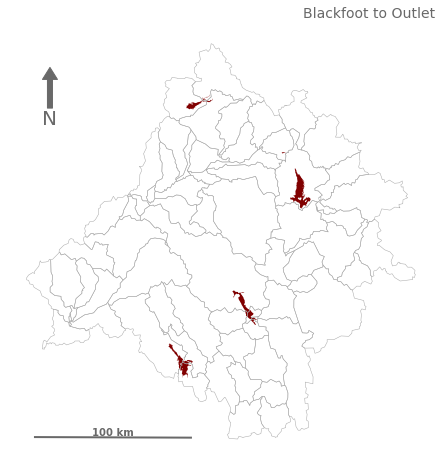

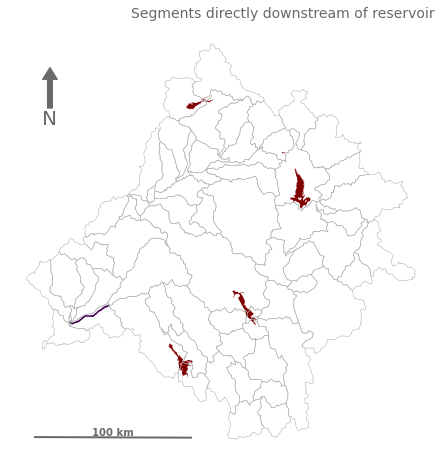

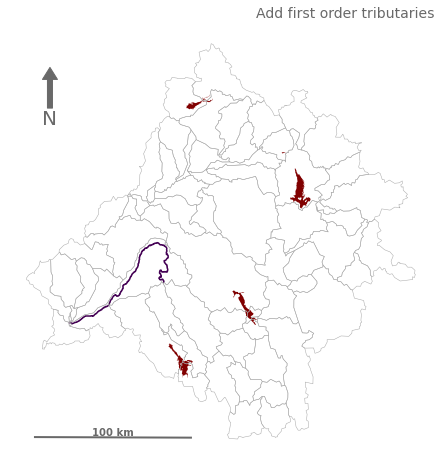

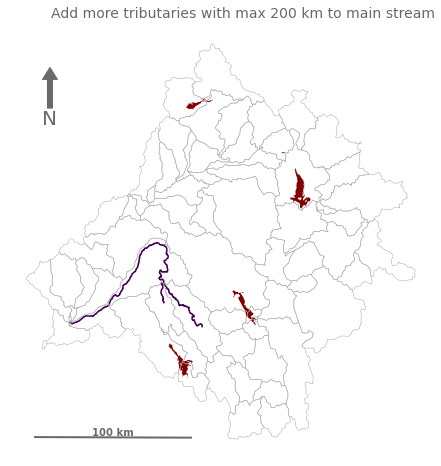

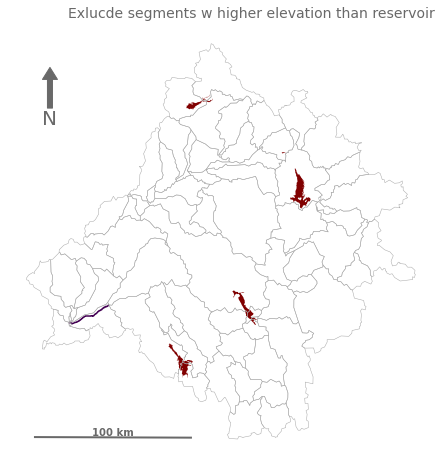

In [ ]:
# Example: Island park
pfaf_res = pfaf_blackfoot
res_name='blackfoot'
pfaf_outlet = pfaf_basin_outlet

# 0. plot empty map
to_plot = []
figname='0_'+res_name+'_empty'
title='Blackfoot to Outlet'
plot_pfaflist(to_plot,figname,title)

# 1. define reservoir stream to outlet
to_plot = get_pfafs_start2end(pfaf_res,pfaf_outlet,river_shp, include_end=False)
figname='1_'+res_name+'_res2outlet'
title='Segments directly downstream of reservoir'
plot_pfaflist(to_plot,figname,title)

# 2. Add first order tributaries
to_plot = get_pfaf_resstream_and_in_tributary_threshold(pfaf_res, pfaf_outlet, river_shp, 100)
figname='2_'+res_name+'_1sttrib'
title='Add first order tributaries'
plot_pfaflist(to_plot,figname, title)

# 3. Add first order tributaries
threshold=200e3 # 100km
to_plot = get_pfaf_resstream_and_in_tributary_threshold(pfaf_res, pfaf_outlet, river_shp, threshold)
figname='3_'+res_name+'_alltrib'
title='Add more tributaries with max '+str(int(threshold*10**-3))+' km to main stream'
plot_pfaflist(to_plot,figname, title)

# 4. Exclude segments that have higher Bottom elev than reservoir Bot elev
pfaf_in_threshold = get_pfaf_resstream_and_in_tributary_threshold(pfaf_res, pfaf_outlet, river_shp, threshold)
to_plot = exclude_higher_botelev(pfaf_in_threshold, pfaf_res, river_shp)
title='Exlucde segments w higher elevation than reservoir'
figname='4_'+res_name+'_belowres'
plot_pfaflist(to_plot,figname, title)

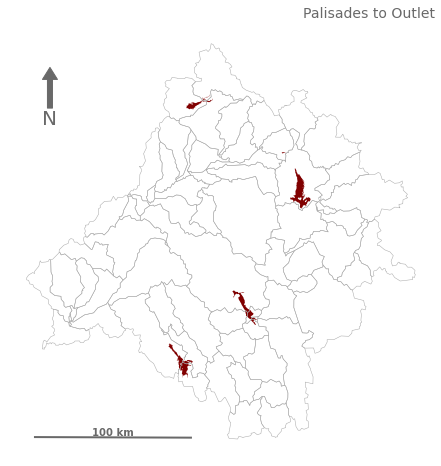

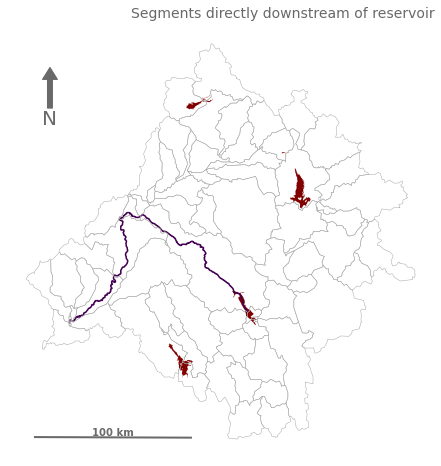

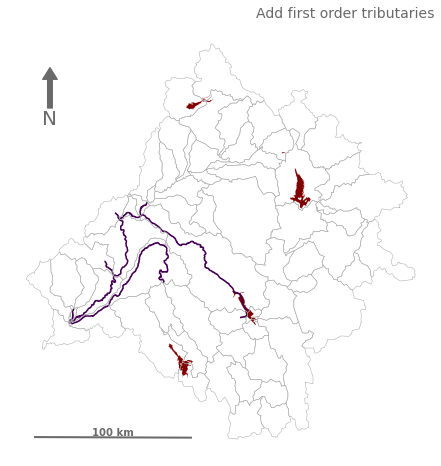

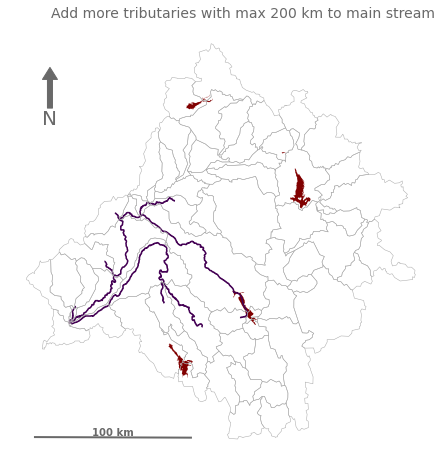

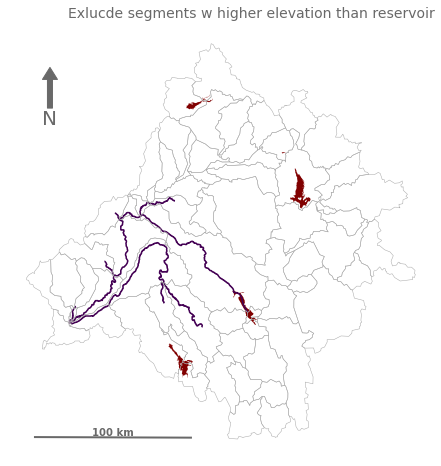

In [ ]:
# Example: Island park
pfaf_res = pfaf_palisades
res_name='palisades'
pfaf_outlet = pfaf_basin_outlet

# 0. plot empty map
to_plot = []
figname='0_'+res_name+'_empty'
title='Palisades to Outlet'
plot_pfaflist(to_plot,figname,title)

# 1. define reservoir stream to outlet
to_plot = get_pfafs_start2end(pfaf_res,pfaf_outlet,river_shp, include_end=False)
figname='1_'+res_name+'_res2outlet'
title='Segments directly downstream of reservoir'
plot_pfaflist(to_plot,figname,title)

# 2. Add first order tributaries
to_plot = get_pfaf_resstream_and_in_tributary_threshold(pfaf_res, pfaf_outlet, river_shp, 100)
figname='2_'+res_name+'_1sttrib'
title='Add first order tributaries'
plot_pfaflist(to_plot,figname, title)

# 3. Add first order tributaries
threshold=200e3 # 100km
to_plot = get_pfaf_resstream_and_in_tributary_threshold(pfaf_res, pfaf_outlet, river_shp, threshold)
figname='3_'+res_name+'_alltrib'
title='Add more tributaries with max '+str(int(threshold*10**-3))+' km to main stream'
plot_pfaflist(to_plot,figname, title)

# 4. Exclude segments that have higher Bottom elev than reservoir Bot elev
pfaf_in_threshold = get_pfaf_resstream_and_in_tributary_threshold(pfaf_res, pfaf_outlet, river_shp, threshold)
to_plot = exclude_higher_botelev(pfaf_in_threshold, pfaf_res, river_shp)
title='Exlucde segments w higher elevation than reservoir'
figname='4_'+res_name+'_belowres'
plot_pfaflist(to_plot,figname, title)

### Plot example stream segments which stream segments for reservoir
Here: island park

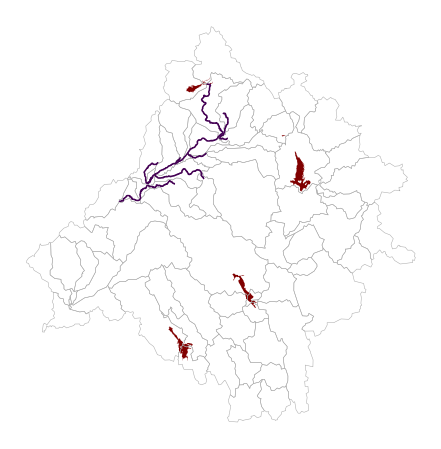

In [95]:
# remap water demand to HRU (now with runoff and rough remapping)
pfaf_res = pfaf_islandpark


pfaf_segments = res_topo_dict[pfaf_res].keys()

subset = pfaf_segments
#subset = pfaf_reservoirs

river_shp['plot'] = np.nan
river_shp.loc[river_shp['PFAF'].isin(subset),'plot'] = 1

fig,ax = plt.subplots(figsize=(8,8))
hrus_shp.boundary.plot(ax=ax, color='darkgray', linewidth=0.5)
river_shp.plot(ax=ax, column='plot')
res_shp.plot(ax=ax, color='maroon')
plt.axis('off'); 


## 8. Testing

### Threshold testing

In [96]:
seg_topo = river_shp
pfafs = get_pfaf_betweenres(pfaf_res,pfaf_outlet,river_shp['PFAF'])
threshold = 10000 # 10 km

# this only includes pfafs of reservoir stream itself (so no tributaries): no upstream tributaries. 

def get_pfaf_in_treshold(threshold, pfaf_res,pfaf_outlet,river_shp): 
    """Get pfafs of stream network within distance threshold from reservoir"""
    df_length = get_streamlength_cumsum(pfaf_res,pfaf_outlet,river_shp)        
    return df_length.loc[df_length['length_cum'] < threshold,'PFAF']

## Tributary testing

In [97]:
# function get_pfaf_betweenres()

# def of variables
all_pfafs = river_shp['PFAF']
pfaf_res = pfaf_blackfoot


# find all pfaf codes of segments upstream of Palisades
pfaf_subbasin = pfaf.get_subbasin(all_pfafs, pfaf_outlet, include_closed=False)

# identify upstream basin of reservoir and exclude from pfafs_subbasin
pfaf_betweenres= []
for i in pfaf_subbasin: 
    if not pfaf.check_upstream(i,pfaf_res) and i!=pfaf_outlet: # only include reaches downstream of reservoir 
        pfaf_betweenres.append(i)

#tributaries = get_all_tributaries(pfafs)

# reservoir on mainstream
if pfaf_res in  get_mainstream(pfafs): 
    print('reservoir on mainstream')

# exclude segments that have higher BottomElev than reservoir BotElev
botelev_res = seg_topo.loc[seg_topo['PFAF']==pfaf_res,'BotElev'].values[0]
pfaf_belowres = seg_topo.loc[seg_topo.PFAF.isin(pfaf_betweenres) & (seg_topo.BotElev < botelev_res), 'PFAF']




TypeError: get_mainstream() missing 1 required positional argument: 'pfaf_outlet'

In [ ]:
pfaf_res = pfaf_islandpark



# find all reaches between Jackson lake (res) and Palisades (outlet)
pfaf_res2outlet = get_pfaf_betweenres(pfaf_res,pfaf_outlet,seg_topo['PFAF'])

# Exclude segments that have higher BottomElev than reservoir BotElev
pfaf_belowres = exclude_higher_botelev(pfaf_res2outlet, pfaf_res, seg_topo)

# Exlcude segments upstream of other reservoirs and segments of other reservoirs themselves as well
pfafs_without_upstream_other_res = exclude_upstream_other_res(pfaf_belowres.values,pfaf_reservoirs)


# get pfaf codes of all segments depenend on reservoir
pfaf_segment_res = seg_topo.loc[seg_topo.PFAF.isin(pfafs_without_upstream_other_res),'PFAF'].values


### Plot test subset

### Plotting of examples

In [ ]:
# plot demand
res_shp['Demand'] = np.nan

for pfaf_res in demand_dict: 
    res_shp.loc[res_shp['PFAF']== pfaf_res,'Demand'] = demand_dict[pfaf_res] * 86400


# do plotting
fig,ax = plt.subplots(figsize=(8,8))
hrus_shp.boundary.plot(ax=ax, color='darkgray', linewidth=0.5)
river_shp.plot(ax=ax)
res_shp.plot(ax=ax, column='Demand', legend=True, cmap='gnuplot',legend_kwds={'label': "reservoir water demand (mm/day)",   'orientation': "horizontal", 'pad' : 0.001})

plt.axis('off'); 



### Old plotting

In [ ]:
# to adjust for new dictionary structure

# check which values are taken to sum 
pfaf_res_selected = pfaf_jackson

# there are not the same amount fo hrus as river segments. Correct for this before plotting
hru_pfafs = np.array(hrus_shp['PFAF'][hrus_shp['PFAF'].isin(res_topo_dict[pfaf_res_selected]['pfafs'])].values)
ind_not_in_hru = np.argwhere(np.in1d(np.array(res_topo_dict[pfaf_res_selected]['pfafs']),hru_pfafs)==False).squeeze()
weights = res_topo_dict[pfaf_res_selected]['weights']
if ind_not_in_hru.size >1:
    for index in sorted(ind_not_in_hru, reverse=True):
        del weights[index]
else: 
    weights = res_topo_dict[pfaf_res_selected]['weights'].pop(ind_not_in_hru)
    
    
hrus_shp['weights'] = np.nan
hrus_shp.loc[hrus_shp['PFAF'].isin(res_topo_dict[pfaf_res_selected]['pfafs']) ,'weights'] = weights


# do plotting
fig,ax = plt.subplots(figsize=(6,6))

hrus_shp.boundary.plot(ax=ax, color='darkgray', linewidth=0.5)
hrus_shp.plot(ax=ax, column='weights',cmap='Greens',legend=True ,legend_kwds={'label': "irrigation weights",   'orientation': "horizontal", 'pad' : 0.001})

res_shp.plot(ax=ax, color='maroon')
river_shp.plot(ax=ax)
plt.axis('off'); 



### OLD testing

In [ ]:
# loop over reservoir and their respective outlets

pfaf_reservoirs = [pfaf_jackson, pfaf_islandpark, pfaf_blackfoot, pfaf_palisades]
pfaf_outlets = [pfaf_palisades, pfaf_basin_outlet, pfaf_basin_outlet, pfaf_basin_outlet]

pfaf_res = pfaf_blackfoot
pfaf_outlet = pfaf_basin_outlet
seg_topo = river_shp
dependency_dict = {}

#for pfaf_res,pfaf_outlet in zip(pfaf_reservoirs,pfaf_outlets):

pfaf_res2outlet = get_pfaf_betweenres(pfaf_res,pfaf_outlet,seg_topo['PFAF'])
botelev_res = seg_topo.loc[seg_topo['PFAF']==pfaf_res,'BotElev'].values[0]
pfaf_belowres = seg_topo.loc[seg_topo.PFAF.isin(pfaf_res2outlet) & (seg_topo.BotElev < botelev_res), 'PFAF']
print(pfaf_res)
# get pfaf codes of all segments depenend on reservoir
pfaf_segment_res = seg_topo.loc[seg_topo.PFAF.isin(pfaf_belowres),'PFAF'].values
print(pfaf_segment_res)

for pfaf_seg in pfaf_segment_res: 
    # check if river pfaf has already dependend res
    if pfaf_seg in dependency_dict: 
        # append to already existent list
        dependency_dict[pfaf_seg] =  dependency_dict[pfaf_seg] + [pfaf_res]
    else: 
        dependency_dict[pfaf_seg] = [pfaf_res]
   # print(dependency_dict)

In [ ]:
# get tributaries of given pfaf list
pfafs = seg_topo['PFAF']


In [ ]:
# get immeadiate downstream pfaf code

# select pfafs smaller than pfaf_res
smaller_pfafs = []
for pfaf in pfafs: 
    if pfaf_res>pfaf: 
        smaller_pfafs.append(pfaf)

pfaf_res

pfaf_downstream = max(smaller_pfafs) 
mainstream = [pfaf_downstream,pfaf_res]


In [ ]:
keys = ['31249844', '31249822', '31249862', '31249845', '31249812', '31249832', '31249863', '31249814', '31249842', '3124988', '31249861', '3124989', '31249843', '31249841', '31249823', '3124987', '31249821', '3124985', '31249833', '31249831', '31249815', '31249813', '31249811']

In [52]:
keys = tributaries['31249773']['3124978']

NameError: name 'tributaries' is not defined

In [9]:
pfaf_res = pfaf_blackfoot
pfaf_outlet = pfaf_basin_outlet

#pfaf_res2outlet = get_pfaf_betweenres(pfaf_res,pfaf_outlet,seg_topo['PFAF'])
pfaf_res2outlet = mainstream

# remap water demand to HRU (now with runoff and rough remapping)

river_shp['plot'] = np.nan
river_shp.loc[river_shp['PFAF'].isin(pfaf_res2outlet),'plot'] = 1

fig,ax = plt.subplots(figsize=(12,12))
river_shp.plot(ax=ax, column='plot')
res_shp.plot(ax=ax, color='maroon')
hrus_shp.boundary.plot(ax=ax, color='darkgray', linewidth=0.5)
plt.axis('off'); 

NameError: name 'mainstream' is not defined

In [261]:
# check if pfaf a is immediate up or downstream of b
# the upstream arguments is given if you already know it is somewhere upstream. 

#  https://rdrr.io/cran/HydroCode/src/R/upstream.R 

pfaf_a = pfaf_res 
pfaf_b = pfaf_outlet

def is_updown(pfaf_a,pfaf_b, upstream)
"""
Check if pfaf code is directly downstream of """

if len(pfaf_a) > len(pfaf_b): 
    print('higher level a is compared to lower level b, truncate b to the same level as a')
    pfaf_b = pfaf_b[0:len(pfaf_a)-1]
elif len(pfaf_b) > len(pfaf_a): 
    print('higher level b is compared to lower level a, truncate b to the same level as a')
    pfaf_a = pfaf_a[0:len(pfaf_b)-1]

# if they are identical, return true    
if pfaf_b == pfaf_a: 
    x = True
    #return True

# shortens number of tests
if upstream: 
    # is larger? 
    cond2 = int(pfaf_a) > int(pfaf_b)
    print(cond2)
    if not cond2: 
        x = False
        # return false
elif not upstream: 
    # is smaller? 
    cond2 = int(pfaf_a) < int(pfaf_b)
    
    if not cond2: 
        x = False
        #return False
        
for i in range(0,len(pfaf_a)):
    lead_a = pfaf_a[0:i]
    basinOK = pfaf_b.startswith(lead_a)
    if not basinOK: 
        break
    # get trailing digits
    trail_a = pfaf_a[i:]
    trail_b = pfaf_b[i:]

    # check if all are odd
if upstream: 
    x = all(int(b) % 2 == 1 for b in trail_b)
else: 
    x = all(int(b) % 2 == 1 for b in trail_a)
        
# all odd? 
x

False

In [53]:
tributaries = get_all_tributaries(pfafs)

AttributeError: 'str' object has no attribute 'get_tributaries'

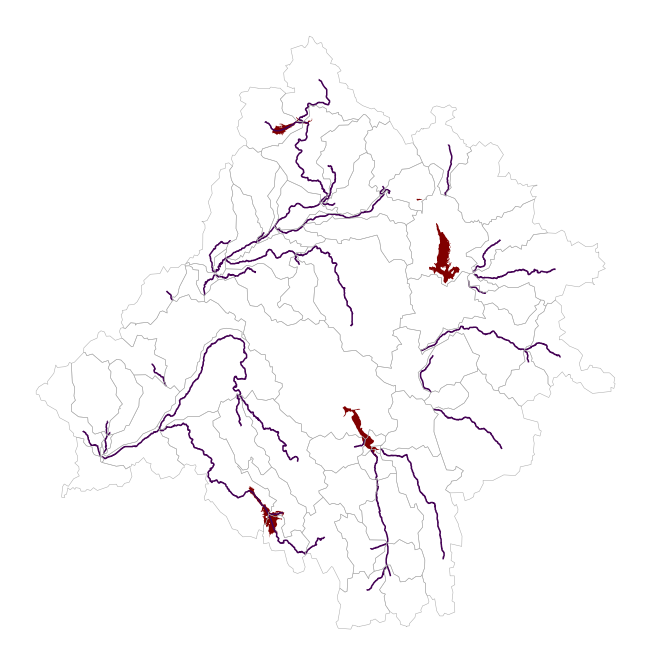

In [183]:
pfaf_res = pfaf_blackfoot
pfaf_outlet = pfaf_basin_outlet

#pfaf_res2outlet = get_pfaf_betweenres(pfaf_res,pfaf_outlet,seg_topo['PFAF'])
pfaf_res2outlet = trib_list

# remap water demand to HRU (now with runoff and rough remapping)

river_shp['plot'] = np.nan
river_shp.loc[river_shp['PFAF'].isin(pfaf_res2outlet),'plot'] = 1

fig,ax = plt.subplots(figsize=(12,12))
river_shp.plot(ax=ax, column='plot')
res_shp.plot(ax=ax, color='maroon')
hrus_shp.boundary.plot(ax=ax, color='darkgray', linewidth=0.5)
plt.axis('off'); 